### 목표 : 미니배치기반 기계학습 진행 실습

-   확률적경사하강법 기반의 알고리즘 적용 모델
-   전체 데이터의 처음부터 끝까지(에포크) 학습 후 가중치(W)와 절편(b) 업데이트 하는 방식에서 에포크를 미니배치 크기만큼 나누어서 학습 후 가중치(W)와 절편(b) 업데이트 진행함
-   장점
    -   온라인 학습 즉, 점진적 학습 가능 => partial_fit() : 기존 모델에 추가로 1에포크 학습
    -   기존의 다른 모델보다 속도 빠름 => 랜덤으로 한개 데이터 추출 후 학습 진행
    -   조기 학습 중단 설정 가능
-   단점
    -   전체 학습보다 정확도는 떨어질 수 있음!


[1] 모듈 로딩 및 데이터 준비 <hr>


In [71]:
# 모듈 로딩
import pandas as pd

data = "../data/fish.csv"


In [72]:
# 데이터 로딩
fishDF = pd.read_csv(data)
fishDF


,Species,Weight,Length,Diagonal,Height,Width
0,Bream,242.0,25.4,30.0,11.5200,4.0200
1,Bream,290.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,26.5,31.1,12.3778,4.6961
3,Bream,363.0,29.0,33.5,12.7300,4.4555
4,Bream,430.0,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...
154,Smelt,12.2,12.2,13.4,2.0904,1.3936
155,Smelt,13.4,12.4,13.5,2.4300,1.2690
156,Smelt,12.2,13.0,13.8,2.2770,1.2558
157,Smelt,19.7,14.3,15.2,2.8728,2.0672


[2] 데이터 전처리 => 학습을 위한 가공 <hr>


[2-1] 피쳐/타겟 분리


In [73]:
featureDF = fishDF[fishDF.columns[1:]]
targetDF = fishDF["Species"]

print(f"피쳐 => {featureDF.shape}, 타겟 => {targetDF.shape}")


피쳐 => (159, 5), 타겟 => (159,)


[2-2] 학습/테스트용 데이터셋 분리


In [74]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    featureDF, targetDF, random_state=41, stratify=targetDF
)


In [75]:
print(f"[훈련용] => {x_train.shape}, {y_train.shape}")
print(f"[테스트용] => {x_test.shape}, {y_test.shape}")


[훈련용] => (119, 5), (119,)
[테스트용] => (40, 5), (40,)


[2-3] 피쳐 => 스케일링


In [76]:
# 스케일러 생성
from sklearn.preprocessing import StandardScaler

sdScaler = StandardScaler()
sdScaler.fit(x_train)


StandardScaler()

In [77]:
# 훈련용 데이터셋 스케일링
scaled_x_train = sdScaler.transform(x_train)

# 데스트용 데이터셋 스케일링
scaled_x_test = sdScaler.transform(x_test)


[3] 학습 진행 <hr>

-   학습 방법 : 확률적경사하강법(SGD) 기반의 분류


In [105]:
# 모델 인스턴스 생성
from sklearn.linear_model import SGDClassifier

model1 = SGDClassifier(random_state=41, verbose=0, loss="log_loss", alpha=0.0000001)
model1.fit(scaled_x_train, y_train)


SGDClassifier(alpha=1e-07, loss='log_loss', random_state=41)

In [106]:
train_score1 = model1.score(scaled_x_train, y_train)
test_score1 = model1.score(scaled_x_test, y_test)


In [107]:
print(f"[기본 SGD] 학습 점수 : {train_score1}, 테스트 점수 : {test_score1}")


[기본 SGD] 학습 점수 : 0.7899159663865546, 테스트 점수 : 0.675


In [108]:
# 학습 후 설정된 파라미터 즉 모델 파라미터
print(f"n_iter_ : {model1.n_iter_}")


n_iter_ : 18


-   1에포크씩 점진적으로 학습 진행 => partial_fit()


In [82]:
# 모델 인스턴스 생성
model2 = SGDClassifier(loss="log_loss")
model2.partial_fit(scaled_x_train, y_train, classes=y_train.unique())


SGDClassifier(loss='log_loss')

In [83]:
train_score2 = model2.score(scaled_x_train, y_train)
test_score2 = model2.score(scaled_x_test, y_test)


In [84]:
print(f"[기본 SGD] 학습 점수 : {train_score2}, 테스트 점수 : {test_score2}")


[기본 SGD] 학습 점수 : 0.7563025210084033, 테스트 점수 : 0.725


In [85]:
train_score, test_score = [], []
count = 0
for n in range(1, 100):
    model2.partial_fit(scaled_x_train, y_train, classes=y_train.unique())
    train_score2 = model2.score(scaled_x_train, y_train)
    test_score2 = model2.score(scaled_x_test, y_test)
    # print(f'[{n}번 학습] [기본 SGD] 학습 점수 : {train_score2}, 테스트 점수 : {test_score2}')
    train_score.append(train_score2)
    test_score.append(test_score2)
    if (test_score2 >= 0.9) and (abs(test_score2 - train_score2) < 0.03):
        #     count += 1
        # if count >= 3:
        break
print(f"n => {n}")


n => 37


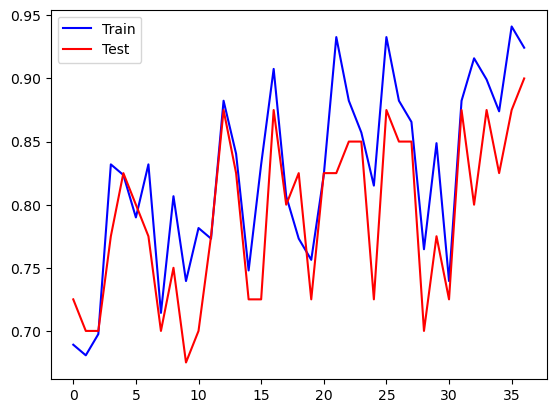

In [86]:
# 시각화
import matplotlib.pyplot as plt

plt.plot(train_score, "b-", label="Train")
plt.plot(test_score, "r-", label="Test")
plt.legend()
plt.show()
